In [1]:
from datetime import datetime
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sentence_transformers import SentenceTransformer

import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score,confusion_matrix  # Change if needed
from tqdm import tqdm
import joblib
import os
import seaborn as sns
import matplotlib.pyplot as plt

# 2.1. Load Data
events = pd.read_csv('train_events.csv')
video_info = pd.read_csv('video_info_v2.csv')
targets = pd.read_csv('train_targets.csv')


In [2]:
region_offset = {
    'Chelyabinsk': 5,
    'Bashkortostan Republic': 5,
    'St.-Petersburg': 3,
    'Moscow': 3,
    'Rostov': 3,
    'Moscow Oblast': 3,
    'Kursk Oblast': 3,
    'Kemerovo Oblast': 7,
    'Arkhangelskaya': 3,
    'Tomsk Oblast': 7,
    'Novosibirsk Oblast': 7,
    'Sverdlovsk Oblast': 5,
    'Leningradskaya Oblast': 3,
    'Krasnodar Krai': 3,
    'Tatarstan Republic': 3,
    'Belgorod Oblast': 3,
    'Kuzbass': 7,
    'Udmurtiya Republic': 4,
    'Chuvashia': 3,
    'Ryazan Oblast': 3,
    'Perm Krai': 5,
    'Sakha': 9,
    'Orenburg Oblast': 5,
    'Primorye': 10,
    'Zabaykalskiy Transbaikal Kray': 9,
    'Bryansk Oblast': 3,
    'Tver Oblast': 3,
    'Stavropol Kray': 3,
    'Khabarovsk': 10,
    'Penza Oblast': 3,
    'Mariy-El Republic': 3,
    'Smolensk Oblast': 3,
    'Tambov Oblast': 3,
    'Novgorod Oblast': 3,
    'Khakasiya Republic': 7,
    'Ulyanovsk': 4,
    'Volgograd Oblast': 3,
    'Irkutsk Oblast': 8,
    'Komi': 3,
    'Nizhny Novgorod Oblast': 3,
    'Krasnoyarsk Krai': 7,
    'Kurgan Oblast': 5,
    'Kirov Oblast': 3,
    'Omsk Oblast': 6,
    'Vladimir Oblast': 3,
    'Yaroslavl Oblast': 3,
    'Saratov Oblast': 4,
    'Khanty-Mansia': 5,
    'Tula Oblast': 3,
    'Amur Oblast': 9,
    'Altay Kray': 7,
    'Buryatiya Republic': 8,
    'Dagestan': 3,
    'Kaluga Oblast': 3,
    'Kaliningrad Oblast': 2,
    'Murmansk': 3,
    'Samara Oblast': 4,
    'Stavropol Kray': 3,
    'Voronezh Oblast': 3,
    'Kursk': 3,
    'Sverdlovsk': 5,
    'Karelia': 3,
    'Lipetsk Oblast': 3,
    'Adygeya Republic': 3,
    'Ivanovo Oblast': 3,
    'Oryol Oblast': 3,
    'Tula': 3,
    'Kamchatka': 12,
    'Tyumen Oblast': 5,
    'Krasnodarskiy': 3,
    'Krasnoyarskiy': 7,
    'Pskov Oblast': 3,
    'Crimea': 3,
    'Chechnya': 3,
    'Saratovskaya Oblast': 4,
    'Kalmykiya Republic': 3,
    'North Ossetia–Alania': 3,
    'Vologda Oblast': 3,
    'Karachayevo-Cherkesiya Republic': 3,
    'Voronezh': 3,
    'Chukotka': 12,
    'Mordoviya Republic': 3,
    'Kostroma Oblast': 3,
    'Yamalo-Nenets': 5,
    'Magadan Oblast': 11,
    'Altai': 7,
    'Vladimir': 3,
    'Ivanovo': 3,
    'Astrakhan Oblast': 4,
    'Penza': 3,
    'Kabardino-Balkariya Republic': 3,
    'Jaroslavl': 3,
    'Sakhalin Oblast': 11,
    'Sebastopol City': 3,
    'Tyumen Oblast': 5,
    'Kirov': 3,
    'Orel Oblast': 3,
    'Omsk': 6,
    'Smolenskaya Oblast': 3,
    'Nenets': 3,
    'Tver Oblast': 3,
    'Jewish Autonomous Oblast': 10,
    'Ingushetiya Republic': 3,
    'Kaluga': 3,
    'Kaliningrad': 2,
    'North Ossetia': 3,
    'Perm': 5,
    'Smolensk': 3,
    'Primorskiy Maritime Kray': 10,
    'Vologda': 3,
    'Stavropol Krai': 3,
    'Astrakhan': 4,
    'Transbaikal Territory': 9,
    'Tambov': 3,
    'Tyva Republic': 7,
    'Arkhangelsk Oblast': 3
}

In [3]:
# Map regions to timezone offsets
events['timezone_offset'] = events['region'].map(region_offset)-3

# Adjust timestamp
events['event_timestamp_local'] = pd.to_datetime(events['event_timestamp']) + pd.to_timedelta(events['timezone_offset'], unit='h')


In [4]:
events.columns

Index(['event_timestamp', 'region', 'ua_device_type', 'ua_client_type',
       'ua_os', 'ua_client_name', 'total_watchtime', 'rutube_video_id',
       'viewer_uid', 'timezone_offset', 'event_timestamp_local'],
      dtype='object')

In [5]:
# Merge events with video_info
events = events.merge(video_info, on='rutube_video_id', how='left')

# Merge with targets
data = events.merge(targets, on='viewer_uid', how='left')

In [6]:
total_videos_watched = data.groupby('viewer_uid').size().rename('total_videos_watched')
total_watchtime = data.groupby('viewer_uid')['total_watchtime'].sum().rename('total_watchtime')
avg_watchtime_per_video = data.groupby('viewer_uid')['total_watchtime'].mean().rename('avg_watchtime_per_video')
median_watchtime_per_video = data.groupby('viewer_uid')['total_watchtime'].median().rename('median_watchtime_per_video')
std_watchtime = data.groupby('viewer_uid')['total_watchtime'].std().rename('std_watchtime')


In [7]:
data.columns

Index(['event_timestamp', 'region', 'ua_device_type', 'ua_client_type',
       'ua_os', 'ua_client_name', 'total_watchtime', 'rutube_video_id',
       'viewer_uid', 'timezone_offset', 'event_timestamp_local', 'title',
       'category', 'duration', 'author_id', 'age', 'sex', 'age_class'],
      dtype='object')

In [8]:
data['hour'] = data['event_timestamp_local'].dt.hour
hour_distribution = data.pivot_table(index='viewer_uid', columns='hour', values='rutube_video_id', aggfunc='size', fill_value=0)
hour_distribution.columns = [f'hour_{col}_views' for col in hour_distribution.columns]
most_active_hour = hour_distribution.idxmax(axis=1).rename('most_active_hour').str.extract('(\d+\.\d+)').astype(float)
data['weekday'] = data['event_timestamp_local'].dt.weekday
weekday_views = data.groupby(['viewer_uid', 'weekday']).size().unstack(fill_value=0)
weekday_views.columns = [f'weekday_{col}_views' for col in weekday_views.columns]
data['is_weekend'] = data['weekday'].isin([5, 6]).astype(int)
weekend_views = data.groupby('viewer_uid')['is_weekend'].sum().rename('weekend_views')
avg_viewing_time = data.groupby('viewer_uid')['hour'].mean().rename('avg_viewing_hour')


In [9]:
unique_categories = data.groupby('viewer_uid')['category'].nunique().rename('unique_categories')
most_watched_category = data.groupby(['viewer_uid', 'category']).size().groupby('viewer_uid').idxmax()
most_watched_category = most_watched_category.apply(lambda x: x[1]).rename('most_watched_category')
category_distribution = data.pivot_table(index='viewer_uid', columns='category', values='rutube_video_id', aggfunc='size', fill_value=0)
category_distribution.columns = [f'category_{col}_views' for col in category_distribution.columns]


In [10]:
from scipy.stats import entropy

def compute_entropy(x):
    probabilities = x.value_counts(normalize=True)
    return entropy(probabilities)

content_entropy = data.groupby('viewer_uid')['category'].apply(compute_entropy).rename('content_entropy')


In [11]:
avg_video_duration = data.groupby('viewer_uid')['duration'].mean().rename('avg_video_duration')
data['percentage_watched'] = (data['total_watchtime'] / (data['duration'] / 1000)).clip(upper=1)
avg_percentage_watched = data.groupby('viewer_uid')['percentage_watched'].mean().rename('avg_percentage_watched')


In [12]:
unique_authors = data.groupby('viewer_uid')['author_id'].nunique().rename('unique_authors')
most_watched_author = data.groupby(['viewer_uid', 'author_id']).size().groupby('viewer_uid').idxmax()
most_watched_author = most_watched_author.apply(lambda x: x[1]).rename('most_watched_author')


In [13]:
top_authors = data['author_id'].value_counts().head(30).index
top_author_views = data[data['author_id'].isin(top_authors)].pivot_table(index='viewer_uid', columns='author_id', values='rutube_video_id', aggfunc='size', fill_value=0)
top_author_views.columns = [f'author_{col}_views' for col in top_author_views.columns]


In [14]:
most_used_device = data.groupby(['viewer_uid', 'ua_device_type']).size().groupby('viewer_uid').idxmax()
most_used_device = most_used_device.apply(lambda x: x[1]).rename('most_used_device')


In [15]:
os_distribution = data.pivot_table(index='viewer_uid', columns='ua_os', values='rutube_video_id', aggfunc='size', fill_value=0)
os_distribution.columns = [f'os_{col}_views' for col in os_distribution.columns]

most_used_os = data.groupby(['viewer_uid', 'ua_os']).size().groupby('viewer_uid').idxmax()
most_used_os = most_used_os.apply(lambda x: x[1]).rename('most_used_os')


In [16]:
device_distribution = data.pivot_table(index='viewer_uid', columns='ua_device_type', values='rutube_video_id', aggfunc='size', fill_value=0)
device_distribution.columns = [f'device_{col}_views' for col in device_distribution.columns]


In [17]:
most_used_os = data.groupby(['viewer_uid', 'ua_os']).size().groupby('viewer_uid').idxmax()
most_used_os = most_used_os.apply(lambda x: x[1]).rename('most_used_os')

In [18]:
most_used_browser = data.groupby(['viewer_uid', 'ua_client_name']).size().groupby('viewer_uid').idxmax()
most_used_browser = most_used_browser.apply(lambda x: x[1]).rename('most_used_browser')


In [19]:
browser_distribution = data.pivot_table(index='viewer_uid', columns='ua_client_name', values='rutube_video_id', aggfunc='size', fill_value=0)
browser_distribution.columns = [f'browser_{col}_views' for col in browser_distribution.columns]

In [20]:
user_region = data.groupby('viewer_uid')['region'].agg(pd.Series.mode).rename('region').astype(str)
regions_accessed = data.groupby('viewer_uid')['region'].nunique().rename('regions_accessed')


In [21]:
regions_accessed.unique()

array([ 1,  3,  4,  2,  5,  6,  7,  8, 10,  9, 11])

In [22]:
data['date'] = data['event_timestamp_local'].dt.date
sessions_per_day = data.groupby(['viewer_uid', 'date']).size().groupby('viewer_uid').mean().rename('avg_sessions_per_day')
active_days = data.groupby('viewer_uid')['date'].nunique().rename('total_active_days')

data = data.sort_values(['viewer_uid', 'event_timestamp_local'])
data['prev_timestamp'] = data.groupby('viewer_uid')['event_timestamp_local'].shift(1)
data['time_diff'] = (data['event_timestamp_local'] - data['prev_timestamp']).dt.seconds
data['new_session'] = (data['time_diff'] > 1800) | (data['time_diff'].isnull())
data['session_id'] = data.groupby('viewer_uid')['new_session'].cumsum()

session_duration = data.groupby(['viewer_uid', 'session_id'])['total_watchtime'].sum()
avg_session_duration = session_duration.groupby('viewer_uid').mean().rename('avg_session_duration')


In [23]:
# List of features to merge
feature_frames = [
    total_videos_watched,
    total_watchtime,
    avg_watchtime_per_video,
    median_watchtime_per_video,
    std_watchtime,
    hour_distribution,
    most_active_hour,
    weekday_views,
    weekend_views,
    avg_viewing_time,
    unique_categories,
    most_watched_category,
    category_distribution,
    content_entropy,
    avg_video_duration,
    avg_percentage_watched,
    unique_authors,
    most_watched_author,
    top_author_views,
    most_used_device,
    device_distribution,
    most_used_os,
    os_distribution,
    most_used_browser,
    browser_distribution,
    user_region,
    regions_accessed,
    sessions_per_day,
    active_days,
    avg_session_duration,
]

# Merge all features
from functools import reduce

features = reduce(lambda left, right: pd.DataFrame(left).join(pd.DataFrame(right), how='outer'), feature_frames)
features = features.reset_index()

# Merge with target variables
features = features.merge(targets, on='viewer_uid', how='left')


In [24]:
# Fill missing numerical values with 0
numerical_cols = features.select_dtypes(include=['float64', 'int64']).columns
features[numerical_cols] = features[numerical_cols].fillna(0)

# Handle categorical missing values if any (you can choose to fill with a placeholder or leave them as is)
categorical_cols = ['most_watched_category', 'most_watched_author', 'most_used_device', 'most_used_os', 'most_used_browser', 'region']
features[categorical_cols] = features[categorical_cols].fillna('unknown')


In [25]:
print([s for s in features.columns])

['viewer_uid', 'total_videos_watched', 'total_watchtime', 'avg_watchtime_per_video', 'median_watchtime_per_video', 'std_watchtime', 'hour_0.0_views', 'hour_1.0_views', 'hour_2.0_views', 'hour_3.0_views', 'hour_4.0_views', 'hour_5.0_views', 'hour_6.0_views', 'hour_7.0_views', 'hour_8.0_views', 'hour_9.0_views', 'hour_10.0_views', 'hour_11.0_views', 'hour_12.0_views', 'hour_13.0_views', 'hour_14.0_views', 'hour_15.0_views', 'hour_16.0_views', 'hour_17.0_views', 'hour_18.0_views', 'hour_19.0_views', 'hour_20.0_views', 'hour_21.0_views', 'hour_22.0_views', 'hour_23.0_views', 0, 'weekday_0.0_views', 'weekday_1.0_views', 'weekday_2.0_views', 'weekday_3.0_views', 'weekday_4.0_views', 'weekday_5.0_views', 'weekday_6.0_views', 'weekend_views', 'avg_viewing_hour', 'unique_categories', 'most_watched_category', 'category_Авто-мото_views', 'category_Аниме_views', 'category_Аудио_views', 'category_Аудиокниги_views', 'category_Бизнес и предпринимательство_views', 'category_Видеоигры_views', 'category

In [26]:
train_df = features.drop(columns = ['age','sex','age_class'])


In [27]:
features.iloc[:,29].unique()

array([ 1.,  0.,  2.,  3.,  5.,  4.,  8.,  7., 11., 10.,  6., 15., 17.,
       13., 16., 21., 22.,  9., 12., 23., 14., 20., 18., 19., 38., 24.,
       31., 25., 34., 26., 29., 30., 28.])

In [28]:


# 1. Data Preparation
# ===================
# Load your preprocessed data
df = features
df['sex'] = 1*(df['sex']=='male')
# Display first few rows
print("First few rows of the dataset:")
print(df.head())

# 2. Identifying Categorical Features
# ===================================
categorical_features = [
    'most_watched_category', 
    'most_watched_author', 
    'most_used_device', 
    'most_used_os', 
    'most_used_browser', 
    'region'
    # Add any other categorical feature names here
]

# Verify categorical features exist
print("\nVerifying categorical features:")
for col in categorical_features:
    if col not in df.columns:
        print(f"Warning: {col} is not present in the DataFrame.")

# 3. Cross-Validation Setup
# =========================
N_SPLITS = 5
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

# 4. CatBoost Classifier Configuration
# =====================================
catboost_params = {
    'iterations': 1000,
    'learning_rate': 0.05,
    'depth': 6,
    'eval_metric': 'TotalF1',  # Change based on your metric
    'random_seed': 42,
    'logging_level': 'Verbose',
    'early_stopping_rounds': 50
}

# 5. Training and OOF Predictions
# ================================
oof_preds = np.zeros(df.shape[0])
oof_true = df['sex'].values  # Replace 'age' with your target column name

feature_importances = pd.DataFrame()
feature_importances['feature'] = df.drop(['viewer_uid', 'age_class'], axis=1).columns  # Adjust as needed

for fold, (train_idx, val_idx) in enumerate(tqdm(skf.split(df.drop(['viewer_uid','age','sex' ,'age_class'], axis=1), df['sex']), 
                                                 total=N_SPLITS, 
                                                 desc='Folding')):
    print(f"\nTraining fold {fold + 1}...")
    
    X_train, X_val = df.iloc[train_idx].drop(['viewer_uid', 'age','sex','age_class'], axis=1), df.iloc[val_idx].drop(['viewer_uid', 'age','sex','age_class'], axis=1)
    y_train, y_val = df.iloc[train_idx]['sex'], df.iloc[val_idx]['sex']
    
    model = CatBoostClassifier(**catboost_params)
    
    model.fit(
        X_train, y_train,
        eval_set=(X_val, y_val),
        cat_features=categorical_features,
        verbose=True
    )
    
    val_preds = model.predict(X_val).flatten()
    oof_preds[val_idx] = val_preds
    
    fold_importance = pd.Series(model.feature_importances_, index=X_train.columns)
    feature_importances[f'fold_{fold + 1}'] = fold_importance
    
    fold_score = accuracy_score(y_val, val_preds)
    print(f"Fold {fold + 1} Accuracy: {fold_score:.4f}")


First few rows of the dataset:
   viewer_uid  total_videos_watched  total_watchtime  avg_watchtime_per_video  \
0    10000001                    19            68757              3618.789474   
1    10000002                     9            15220              1691.111111   
2    10000004                    12            16501              1375.083333   
3    10000005                     1              212               212.000000   
4    10000006                     1              971               971.000000   

   median_watchtime_per_video  std_watchtime  hour_0.0_views  hour_1.0_views  \
0                      4003.0    1864.664569             1.0             0.0   
1                      1210.0    1913.552158             1.0             0.0   
2                       613.0    1419.391064             0.0             0.0   
3                       212.0       0.000000             0.0             0.0   
4                       971.0       0.000000             0.0             0.0   

 

Folding:   0%|                                            | 0/5 [00:00<?, ?it/s]


Training fold 1...
0:	learn: 0.7068061	test: 0.7068648	best: 0.7068648 (0)	total: 88.9ms	remaining: 1m 28s
1:	learn: 0.7107531	test: 0.7109870	best: 0.7109870 (1)	total: 136ms	remaining: 1m 8s
2:	learn: 0.7118174	test: 0.7113608	best: 0.7113608 (2)	total: 172ms	remaining: 57.3s
3:	learn: 0.7134137	test: 0.7127229	best: 0.7127229 (3)	total: 219ms	remaining: 54.5s
4:	learn: 0.7152578	test: 0.7156573	best: 0.7156573 (4)	total: 265ms	remaining: 52.8s
5:	learn: 0.7150932	test: 0.7150189	best: 0.7156573 (4)	total: 313ms	remaining: 51.9s
6:	learn: 0.7169074	test: 0.7179651	best: 0.7179651 (6)	total: 354ms	remaining: 50.3s
7:	learn: 0.7163480	test: 0.7168226	best: 0.7179651 (6)	total: 391ms	remaining: 48.4s
8:	learn: 0.7164200	test: 0.7170864	best: 0.7179651 (6)	total: 436ms	remaining: 48s
9:	learn: 0.7164487	test: 0.7177269	best: 0.7179651 (6)	total: 474ms	remaining: 47s
10:	learn: 0.7247669	test: 0.7266614	best: 0.7266614 (10)	total: 519ms	remaining: 46.7s
11:	learn: 0.7286721	test: 0.73031

Folding:  20%|███████▏                            | 1/5 [00:26<01:46, 26.70s/it]

Fold 1 Accuracy: 0.7513

Training fold 2...
0:	learn: 0.7062692	test: 0.7089467	best: 0.7089467 (0)	total: 43.5ms	remaining: 43.4s
1:	learn: 0.7066701	test: 0.7099818	best: 0.7099818 (1)	total: 79ms	remaining: 39.4s
2:	learn: 0.7079449	test: 0.7108523	best: 0.7108523 (2)	total: 128ms	remaining: 42.6s
3:	learn: 0.7084939	test: 0.7110469	best: 0.7110469 (3)	total: 177ms	remaining: 44.1s
4:	learn: 0.7091022	test: 0.7120056	best: 0.7120056 (4)	total: 217ms	remaining: 43.2s
5:	learn: 0.7090341	test: 0.7119544	best: 0.7120056 (4)	total: 263ms	remaining: 43.5s
6:	learn: 0.7145083	test: 0.7177162	best: 0.7177162 (6)	total: 318ms	remaining: 45.1s
7:	learn: 0.7142025	test: 0.7184081	best: 0.7184081 (7)	total: 372ms	remaining: 46.2s
8:	learn: 0.7140748	test: 0.7174935	best: 0.7184081 (7)	total: 415ms	remaining: 45.6s
9:	learn: 0.7256764	test: 0.7299276	best: 0.7299276 (9)	total: 460ms	remaining: 45.5s
10:	learn: 0.7284625	test: 0.7328073	best: 0.7328073 (10)	total: 502ms	remaining: 45.1s
11:	lear

Folding:  40%|██████████████▍                     | 2/5 [00:42<01:00, 20.03s/it]

284:	learn: 0.7493799	test: 0.7504806	best: 0.7509305 (235)	total: 14.5s	remaining: 36.4s
285:	learn: 0.7494010	test: 0.7505082	best: 0.7509305 (235)	total: 14.6s	remaining: 36.3s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7509305
bestIteration = 235

Shrink model to first 236 iterations.
Fold 2 Accuracy: 0.7510

Training fold 3...
0:	learn: 0.7080715	test: 0.7092934	best: 0.7092934 (0)	total: 46.7ms	remaining: 46.7s
1:	learn: 0.7095675	test: 0.7105003	best: 0.7105003 (1)	total: 90.3ms	remaining: 45.1s
2:	learn: 0.7101424	test: 0.7111834	best: 0.7111834 (2)	total: 131ms	remaining: 43.6s
3:	learn: 0.7101582	test: 0.7112904	best: 0.7112904 (3)	total: 175ms	remaining: 43.5s
4:	learn: 0.7117475	test: 0.7130881	best: 0.7130881 (4)	total: 218ms	remaining: 43.4s
5:	learn: 0.7130531	test: 0.7144678	best: 0.7144678 (5)	total: 272ms	remaining: 45s
6:	learn: 0.7116182	test: 0.7119638	best: 0.7144678 (5)	total: 317ms	remaining: 45s
7:	learn: 0.7118986	test: 0.7126352	best:

Folding:  60%|█████████████████████▌              | 3/5 [01:01<00:39, 19.87s/it]

380:	learn: 0.7542193	test: 0.7487357	best: 0.7491526 (330)	total: 18.9s	remaining: 30.7s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7491526439
bestIteration = 330

Shrink model to first 331 iterations.
Fold 3 Accuracy: 0.7492

Training fold 4...
0:	learn: 0.7103121	test: 0.7091239	best: 0.7091239 (0)	total: 41.6ms	remaining: 41.6s
1:	learn: 0.7132311	test: 0.7119343	best: 0.7119343 (1)	total: 78.6ms	remaining: 39.2s
2:	learn: 0.7137864	test: 0.7127901	best: 0.7127901 (2)	total: 122ms	remaining: 40.5s
3:	learn: 0.7133989	test: 0.7129869	best: 0.7129869 (3)	total: 179ms	remaining: 44.6s
4:	learn: 0.7125668	test: 0.7121996	best: 0.7129869 (3)	total: 214ms	remaining: 42.7s
5:	learn: 0.7137240	test: 0.7133995	best: 0.7133995 (5)	total: 265ms	remaining: 43.8s
6:	learn: 0.7142014	test: 0.7132333	best: 0.7133995 (5)	total: 304ms	remaining: 43.2s
7:	learn: 0.7142936	test: 0.7127600	best: 0.7133995 (5)	total: 340ms	remaining: 42.2s
8:	learn: 0.7180005	test: 0.7160854	be

Folding:  80%|████████████████████████████▊       | 4/5 [01:37<00:26, 26.04s/it]

719:	learn: 0.7615703	test: 0.7474784	best: 0.7481188 (669)	total: 34.6s	remaining: 13.5s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7481188268
bestIteration = 669

Shrink model to first 670 iterations.
Fold 4 Accuracy: 0.7482

Training fold 5...
0:	learn: 0.7117925	test: 0.7080951	best: 0.7080951 (0)	total: 44.2ms	remaining: 44.2s
1:	learn: 0.7122861	test: 0.7077027	best: 0.7080951 (0)	total: 83.4ms	remaining: 41.6s
2:	learn: 0.7124300	test: 0.7078700	best: 0.7080951 (0)	total: 123ms	remaining: 40.9s
3:	learn: 0.7124112	test: 0.7078367	best: 0.7080951 (0)	total: 172ms	remaining: 42.7s
4:	learn: 0.7139577	test: 0.7088593	best: 0.7088593 (4)	total: 222ms	remaining: 44.2s
5:	learn: 0.7167692	test: 0.7126723	best: 0.7126723 (5)	total: 265ms	remaining: 43.9s
6:	learn: 0.7157308	test: 0.7125352	best: 0.7126723 (5)	total: 309ms	remaining: 43.8s
7:	learn: 0.7173933	test: 0.7138781	best: 0.7138781 (7)	total: 355ms	remaining: 44s
8:	learn: 0.7165355	test: 0.7130041	best

Folding: 100%|████████████████████████████████████| 5/5 [01:55<00:00, 23.14s/it]

Fold 5 Accuracy: 0.7490



Overall OOF Accuracy: 0.7497


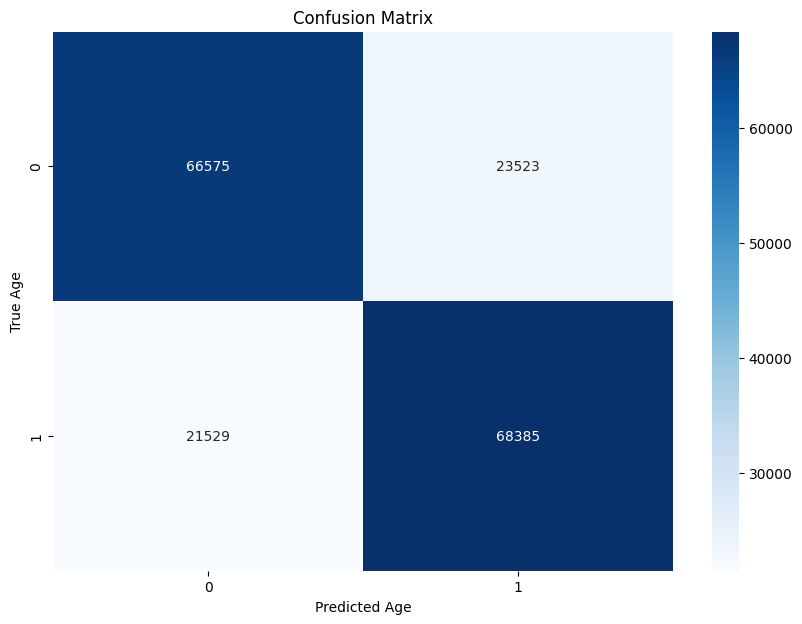

Saved CatBoost model for fold 1 at catboost_models/catboost_fold_1.cbm
Saved CatBoost model for fold 2 at catboost_models/catboost_fold_2.cbm
Saved CatBoost model for fold 3 at catboost_models/catboost_fold_3.cbm
Saved CatBoost model for fold 4 at catboost_models/catboost_fold_4.cbm
Saved CatBoost model for fold 5 at catboost_models/catboost_fold_5.cbm

Saved DataFrame with OOF predictions as 'train_features_with_oof.csv'


In [29]:

# 6. Evaluating Model Performance
# ================================
overall_accuracy = accuracy_score(oof_true, oof_preds)
print(f"\nOverall OOF Accuracy: {overall_accuracy:.4f}")

# Confusion Matrix
cm = confusion_matrix(oof_true, oof_preds)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Age')
plt.ylabel('True Age')
plt.title('Confusion Matrix')
plt.show()

# 7. Saving and Utilizing the Models
# ==================================
os.makedirs('catboost_models', exist_ok=True)

for fold in range(N_SPLITS):
    model_path = f'catboost_models/catboost_fold_{fold + 1}.cbm'
    joblib.dump(model, model_path)
    print(f"Saved CatBoost model for fold {fold + 1} at {model_path}")

# 8. Feature Importances (Optional)
# ==================================
# Averaging feature importances across folds
feature_importances['average_importance'] = feature_importances[[f'fold_{i + 1}' for i in range(N_SPLITS)]].mean(axis=1)
feature_importances = feature_importances.sort_values(by='average_importance', ascending=False)

# 9. Saving OOF Predictions (Optional)
# =====================================
# Add OOF predictions to the original DataFrame
#df['oof_preds'] = oof_preds

# Save the DataFrame with OOF predictions
print("\nSaved DataFrame with OOF predictions as 'train_features_with_oof.csv'")


In [30]:
video_info[video_info['author_id']==1009257]

,rutube_video_id,title,category,duration,author_id
256,video_77748,"Хочу перемен, 2 сезон, 3 выпуск",Телепередачи,1260000,1009257
562,video_360653,"Шоу ""Битва дизайнеров"". 52 выпуск",Телепередачи,1236727,1009257
1734,video_36011,"ЭТО НОРМАЛЬНО?, 1 сезон, 41 выпуск",Телепередачи,2849920,1009257
2252,video_402112,"Милиционер с Рублевки, 2 сезон, 1 серия",Сериалы,1298000,1009257
2613,video_289974,"Влюбись, если сможешь, 1 сезон, 20 выпуск",Телепередачи,4062240,1009257
...,...,...,...,...,...
480435,video_348650,"Однажды в России. Спецдайджесты 2023, 23 сезон...",Телепередачи,2683240,1009257
480569,video_277989,"Бузова на кухне, 2 сезон, 3 выпуск",Телепередачи,1463960,1009257
480714,video_435467,"Шоу ""Студия ""Союз"", 3 сезон, 45 выпуск",Телепередачи,2632800,1009257
480906,video_128965,"Новая Битва экстрасенсов, 24 сезон, 7 выпуск",Телепередачи,5514000,1009257


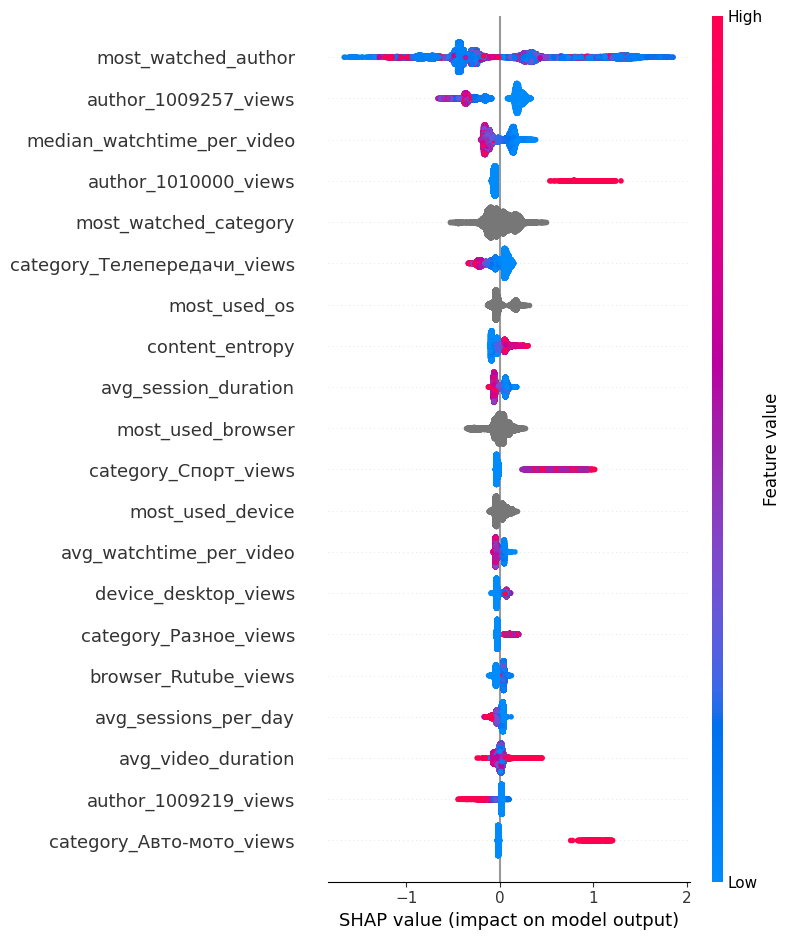

In [31]:
import shap

# Create a SHAP explainer
explainer = shap.TreeExplainer(model)

# Calculate SHAP values for the validation set
shap_values = explainer.shap_values(X_val)

# Visualize the SHAP values
shap.summary_plot(shap_values, X_val)


In [32]:


# 1. Data Preparation
# ===================
# Load your preprocessed data
df = features
# Display first few rows
print("First few rows of the dataset:")
print(df.head())

# 2. Identifying Categorical Features
# ===================================
categorical_features = [
    'most_watched_category', 
    'most_watched_author', 
    'most_used_device', 
    'most_used_os', 
    'most_used_browser', 
    'region'
    # Add any other categorical feature names here
]

# Verify categorical features exist
print("\nVerifying categorical features:")
for col in categorical_features:
    if col not in df.columns:
        print(f"Warning: {col} is not present in the DataFrame.")

# 3. Cross-Validation Setup
# =========================
N_SPLITS = 5
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

# 4. CatBoost Classifier Configuration
# =====================================
catboost_params = {
    'iterations': 1000,
    'learning_rate': 0.05,
    'depth': 6,
    'eval_metric': 'TotalF1',  # Change based on your metric
    'random_seed': 42,
    'logging_level': 'Verbose',
    'early_stopping_rounds': 50
}

# 5. Training and OOF Predictions
# ================================
oof_preds = np.zeros(df.shape[0])
oof_true = df['age_class'].values  # Replace 'age' with your target column name

feature_importances = pd.DataFrame()
feature_importances['feature'] = df.drop(['viewer_uid', 'age_class'], axis=1).columns  # Adjust as needed

for fold, (train_idx, val_idx) in enumerate(tqdm(skf.split(df.drop(['viewer_uid','age','sex' ,'age_class'], axis=1), df['age_class']), 
                                                 total=N_SPLITS, 
                                                 desc='Folding')):
    print(f"\nTraining fold {fold + 1}...")
    
    X_train, X_val = df.iloc[train_idx].drop(['viewer_uid', 'age','sex','age_class'], axis=1), df.iloc[val_idx].drop(['viewer_uid', 'age','sex','age_class'], axis=1)
    y_train, y_val = df.iloc[train_idx]['age_class'], df.iloc[val_idx]['age_class']
    
    model = CatBoostClassifier(**catboost_params)
    
    model.fit(
        X_train, y_train,
        eval_set=(X_val, y_val),
        cat_features=categorical_features,
        verbose=True
    )
    
    val_preds = model.predict(X_val).flatten()
    oof_preds[val_idx] = val_preds
    
    fold_importance = pd.Series(model.feature_importances_, index=X_train.columns)
    feature_importances[f'fold_{fold + 1}'] = fold_importance
    
    fold_score = accuracy_score(y_val, val_preds)
    print(f"Fold {fold + 1} Accuracy: {fold_score:.4f}")


First few rows of the dataset:
   viewer_uid  total_videos_watched  total_watchtime  avg_watchtime_per_video  \
0    10000001                    19            68757              3618.789474   
1    10000002                     9            15220              1691.111111   
2    10000004                    12            16501              1375.083333   
3    10000005                     1              212               212.000000   
4    10000006                     1              971               971.000000   

   median_watchtime_per_video  std_watchtime  hour_0.0_views  hour_1.0_views  \
0                      4003.0    1864.664569             1.0             0.0   
1                      1210.0    1913.552158             1.0             0.0   
2                       613.0    1419.391064             0.0             0.0   
3                       212.0       0.000000             0.0             0.0   
4                       971.0       0.000000             0.0             0.0   

 

Folding:   0%|                                            | 0/5 [00:00<?, ?it/s]


Training fold 1...
0:	learn: 0.4104365	test: 0.4103972	best: 0.4103972 (0)	total: 144ms	remaining: 2m 24s
1:	learn: 0.4140844	test: 0.4143005	best: 0.4143005 (1)	total: 258ms	remaining: 2m 8s
2:	learn: 0.3725399	test: 0.3711967	best: 0.4143005 (1)	total: 388ms	remaining: 2m 8s
3:	learn: 0.3889426	test: 0.3894145	best: 0.4143005 (1)	total: 536ms	remaining: 2m 13s
4:	learn: 0.4170598	test: 0.4191098	best: 0.4191098 (4)	total: 682ms	remaining: 2m 15s
5:	learn: 0.4090880	test: 0.4073921	best: 0.4191098 (4)	total: 795ms	remaining: 2m 11s
6:	learn: 0.3924725	test: 0.3927046	best: 0.4191098 (4)	total: 935ms	remaining: 2m 12s
7:	learn: 0.3894976	test: 0.3900879	best: 0.4191098 (4)	total: 1.03s	remaining: 2m 8s
8:	learn: 0.3919304	test: 0.3915924	best: 0.4191098 (4)	total: 1.18s	remaining: 2m 9s
9:	learn: 0.3930467	test: 0.3932917	best: 0.4191098 (4)	total: 1.3s	remaining: 2m 8s
10:	learn: 0.4031577	test: 0.4050131	best: 0.4191098 (4)	total: 1.44s	remaining: 2m 9s
11:	learn: 0.4032621	test: 0.

Folding:  20%|███████▏                            | 1/5 [01:37<06:28, 97.08s/it]

Fold 1 Accuracy: 0.4802

Training fold 2...
0:	learn: 0.3825178	test: 0.3826399	best: 0.3826399 (0)	total: 156ms	remaining: 2m 36s
1:	learn: 0.3834114	test: 0.3843895	best: 0.3843895 (1)	total: 258ms	remaining: 2m 8s
2:	learn: 0.3883078	test: 0.3880169	best: 0.3880169 (2)	total: 422ms	remaining: 2m 20s
3:	learn: 0.3923924	test: 0.3909361	best: 0.3909361 (3)	total: 580ms	remaining: 2m 24s
4:	learn: 0.3908188	test: 0.3893848	best: 0.3909361 (3)	total: 695ms	remaining: 2m 18s
5:	learn: 0.3899070	test: 0.3886434	best: 0.3909361 (3)	total: 833ms	remaining: 2m 18s
6:	learn: 0.3957455	test: 0.3934515	best: 0.3934515 (6)	total: 974ms	remaining: 2m 18s
7:	learn: 0.3955801	test: 0.3933736	best: 0.3934515 (6)	total: 1.12s	remaining: 2m 19s
8:	learn: 0.3948653	test: 0.3921853	best: 0.3934515 (6)	total: 1.25s	remaining: 2m 18s
9:	learn: 0.3997240	test: 0.3969701	best: 0.3969701 (9)	total: 1.38s	remaining: 2m 16s
10:	learn: 0.4022153	test: 0.4001249	best: 0.4001249 (10)	total: 1.52s	remaining: 2m 17

Folding:  40%|██████████████▍                     | 2/5 [02:51<04:11, 83.77s/it]

Fold 2 Accuracy: 0.4787

Training fold 3...
0:	learn: 0.4109974	test: 0.4102463	best: 0.4102463 (0)	total: 199ms	remaining: 3m 18s
1:	learn: 0.4141914	test: 0.4137007	best: 0.4137007 (1)	total: 372ms	remaining: 3m 5s
2:	learn: 0.3990039	test: 0.3972265	best: 0.4137007 (1)	total: 515ms	remaining: 2m 51s
3:	learn: 0.4052167	test: 0.4010938	best: 0.4137007 (1)	total: 657ms	remaining: 2m 43s
4:	learn: 0.4167485	test: 0.4158335	best: 0.4158335 (4)	total: 841ms	remaining: 2m 47s
5:	learn: 0.4168145	test: 0.4151210	best: 0.4158335 (4)	total: 1.01s	remaining: 2m 48s
6:	learn: 0.4173492	test: 0.4167574	best: 0.4167574 (6)	total: 1.19s	remaining: 2m 48s
7:	learn: 0.4109956	test: 0.4084224	best: 0.4167574 (6)	total: 1.37s	remaining: 2m 49s
8:	learn: 0.4075998	test: 0.4028975	best: 0.4167574 (6)	total: 1.53s	remaining: 2m 48s
9:	learn: 0.4113062	test: 0.4046255	best: 0.4167574 (6)	total: 1.69s	remaining: 2m 46s
10:	learn: 0.4099732	test: 0.4019117	best: 0.4167574 (6)	total: 1.82s	remaining: 2m 44s

Folding:  60%|█████████████████████▌              | 3/5 [04:30<03:01, 90.61s/it]

581:	learn: 0.4824616	test: 0.4664592	best: 0.4671550 (531)	total: 1m 37s	remaining: 1m 10s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.4671549852
bestIteration = 531

Shrink model to first 532 iterations.
Fold 3 Accuracy: 0.4800

Training fold 4...
0:	learn: 0.3798791	test: 0.3763299	best: 0.3763299 (0)	total: 148ms	remaining: 2m 27s
1:	learn: 0.3712607	test: 0.3732793	best: 0.3763299 (0)	total: 314ms	remaining: 2m 36s
2:	learn: 0.3940117	test: 0.3927285	best: 0.3927285 (2)	total: 462ms	remaining: 2m 33s
3:	learn: 0.3927050	test: 0.3934971	best: 0.3934971 (3)	total: 632ms	remaining: 2m 37s
4:	learn: 0.3901239	test: 0.3894136	best: 0.3934971 (3)	total: 762ms	remaining: 2m 31s
5:	learn: 0.3940578	test: 0.3883188	best: 0.3934971 (3)	total: 908ms	remaining: 2m 30s
6:	learn: 0.3949154	test: 0.3901987	best: 0.3934971 (3)	total: 1.08s	remaining: 2m 32s
7:	learn: 0.4063050	test: 0.4030782	best: 0.4030782 (7)	total: 1.23s	remaining: 2m 32s
8:	learn: 0.4020275	test: 0.39

Folding:  80%|████████████████████████████       | 4/5 [06:26<01:40, 100.73s/it]

Fold 4 Accuracy: 0.4798

Training fold 5...
0:	learn: 0.4084236	test: 0.4098748	best: 0.4098748 (0)	total: 164ms	remaining: 2m 43s
1:	learn: 0.4122171	test: 0.4131815	best: 0.4131815 (1)	total: 336ms	remaining: 2m 47s
2:	learn: 0.4157268	test: 0.4186593	best: 0.4186593 (2)	total: 493ms	remaining: 2m 43s
3:	learn: 0.4149003	test: 0.4168140	best: 0.4186593 (2)	total: 621ms	remaining: 2m 34s
4:	learn: 0.4166290	test: 0.4178744	best: 0.4186593 (2)	total: 750ms	remaining: 2m 29s
5:	learn: 0.4180158	test: 0.4200967	best: 0.4200967 (5)	total: 908ms	remaining: 2m 30s
6:	learn: 0.4181748	test: 0.4190887	best: 0.4200967 (5)	total: 1.05s	remaining: 2m 28s
7:	learn: 0.4181863	test: 0.4184596	best: 0.4200967 (5)	total: 1.19s	remaining: 2m 27s
8:	learn: 0.4175159	test: 0.4181999	best: 0.4200967 (5)	total: 1.31s	remaining: 2m 24s
9:	learn: 0.4178275	test: 0.4187383	best: 0.4200967 (5)	total: 1.47s	remaining: 2m 25s
10:	learn: 0.4172032	test: 0.4210010	best: 0.4210010 (10)	total: 1.61s	remaining: 2m 2

Folding: 100%|███████████████████████████████████| 5/5 [08:34<00:00, 102.83s/it]

Fold 5 Accuracy: 0.4830


In [38]:
shap_obj = explainer(X_val)

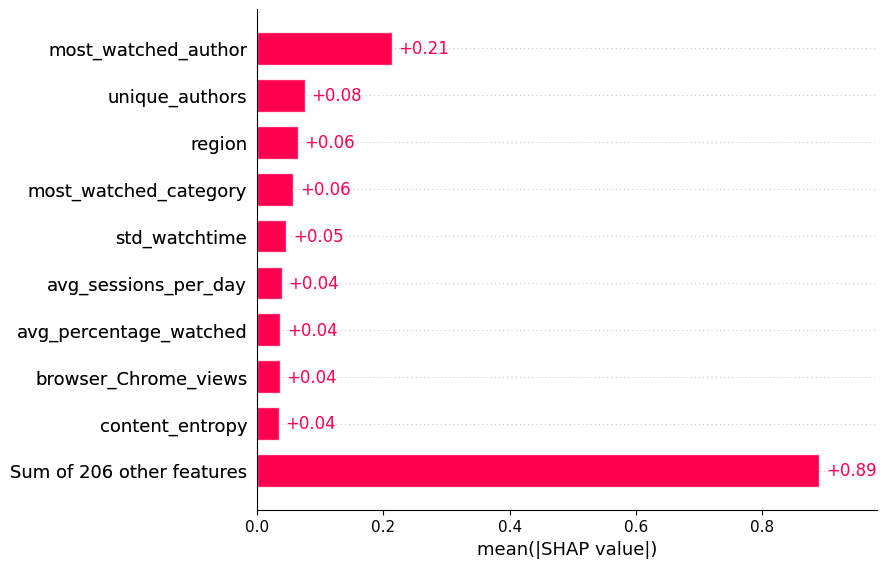

In [39]:
shap.plots.bar(shap_obj[:, :, 0])

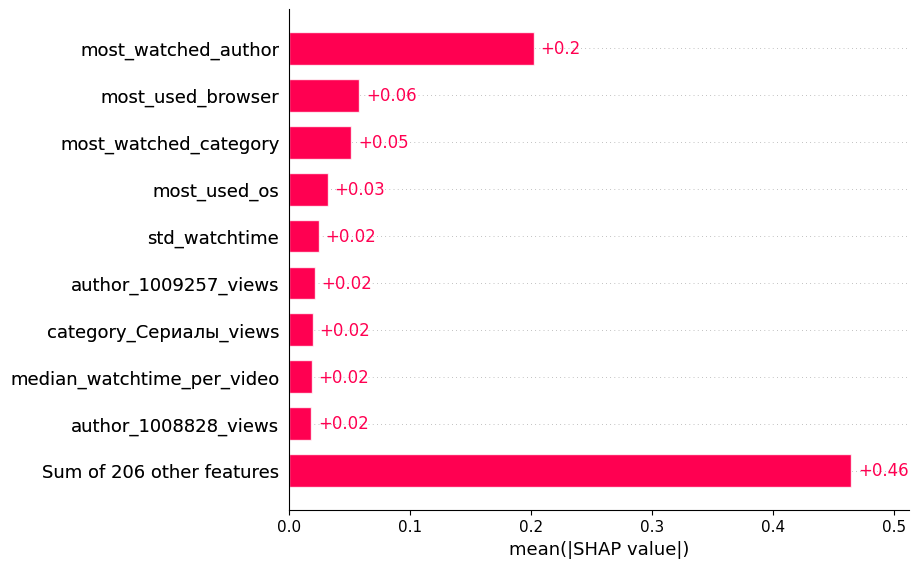

In [40]:
shap.plots.bar(shap_obj[:, :, 1])

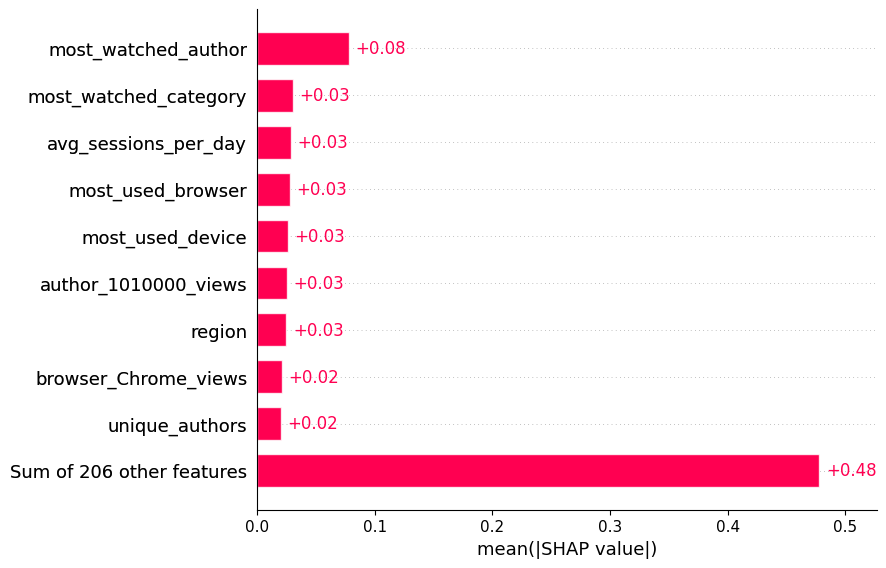

In [41]:
shap.plots.bar(shap_obj[:, :, 2])